- 금융 거래 데이터 분석
- 고객 신용 예측하는 분류모델

- 순서
    - 데이터 읽어오기
    - 데이터 정제
    - 데이터 시각화
    - 데이터 전처리
    - 모델 학습
    - 평가 및 예측
    - 불균형 class 데이터 처리



In [81]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("adityapotdar23/german-credit-data")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Playdata\.cache\kagglehub\datasets\adityapotdar23\german-credit-data\versions\1


- uci 데이터셋을 기반으로
  https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data
  
- kaggle에서 가공해놓은 데이터 사용 .csv
 https://www.kaggle.com/api/v1/datasets/download/adityapotdar23/german-credit-data?dataset_version_number=1.

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns


# 모델
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB      # 나이브 베이즈 분류기
from sklearn.svm import SVC                     # 서포트벡터머신 분류모델
from sklearn.tree import DecisionTreeClassifier # 의사결정 나무
from xgboost import XGBClassifier               # XGBoost 부스팅모델

# 평가지표
from sklearn.metrics import(
    accuracy_score,         # 정확도
    confusion_matrix,       # 혼동 행력
    f1_score,               # f1스코어 (설명력)
    precision_score,        # 정밀도
    recall_score            # 재현율
)

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder      # 데이터 전처리 스케일러, 범주형 변수 인코더

SEED = 2022


In [31]:
# 1. 데이터 읽어오기

df_origin = pd.read_csv("data/german_credit_data.csv", index_col=0)
df_origin.head()


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


### 1994년 독일 특정 은행 예금을 가지고있던 사람들의 데이터
Risk -> 타겟변수 ('good','bad') 두 값만 있음.

변수들
- Age : 나이
- Sex : 성별
- Job : 직업 (직업 숙련도)
    - 0 : 비숙련자/비거주자, 1: 비숙련
- Housing: 주거형태
    - Own: 자가, rent: 임대, free: 정확하지않음
- Saving accounts: 저축 예금 잔고정도
- Checking account : 당좌 예금 잔고 정도
- Credit amount : 예금 보유량 (독일 마르크 기준)
- Duration: 은행에 예금거치기간 (월)
- Purpose: 예금 보유 목적 (특정 물품 구매, 교육용, 휴가용)



In [32]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


In [33]:
df_origin.describe()    # 수치형 변수들 통계 요약

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


# 2. 데이터 정제
- 결측치 처리
- 이상치 처리

In [34]:
df_origin.isnull().sum()    # 결측치의 수 확인

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

### 전체 데이터가 1000개밖에 되지 않아 400개정도의 데이터를 dropna()로 삭제하기에는 데이터가 너무 적다. 그래서 결측치르 대체하는 기법을 사용한다.

In [35]:
df_origin['Saving accounts'].unique()

array([nan, 'little', 'quite rich', 'rich', 'moderate'], dtype=object)

In [36]:
df_origin['Checking account'].unique()

array(['little', 'moderate', nan, 'rich'], dtype=object)

둘다 문자열 형식의 값이기 때문에 nan값은 Others 채워넣는다.


In [85]:
df_clean = df_origin

df_clean['Saving accounts'].fillna("Others",inplace=True)
df_clean['Checking account'].fillna("Others",inplace=True)

C:\Users\Playdata\AppData\Local\Temp\ipykernel_11400\3137527189.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Saving accounts'].fillna("Others",inplace=True)
C:\Users\Playdata\AppData\Local\Temp\ipykernel_11400\3137527189.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

In [88]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Age               1000 non-null   int64
 1   Sex               1000 non-null   int32
 2   Job               1000 non-null   int64
 3   Housing           1000 non-null   int32
 4   Saving accounts   1000 non-null   int32
 5   Checking account  1000 non-null   int32
 6   Credit amount     1000 non-null   int64
 7   Duration          1000 non-null   int64
 8   Purpose           1000 non-null   int32
 9   Risk              1000 non-null   int64
dtypes: int32(5), int64(5)
memory usage: 98.7 KB


In [87]:
df_clean.isnull().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

# 3. 데이터 시각화

각 변수별 상관관계 한번에 확인 : seaborn - pairplot (중점은 Risk)

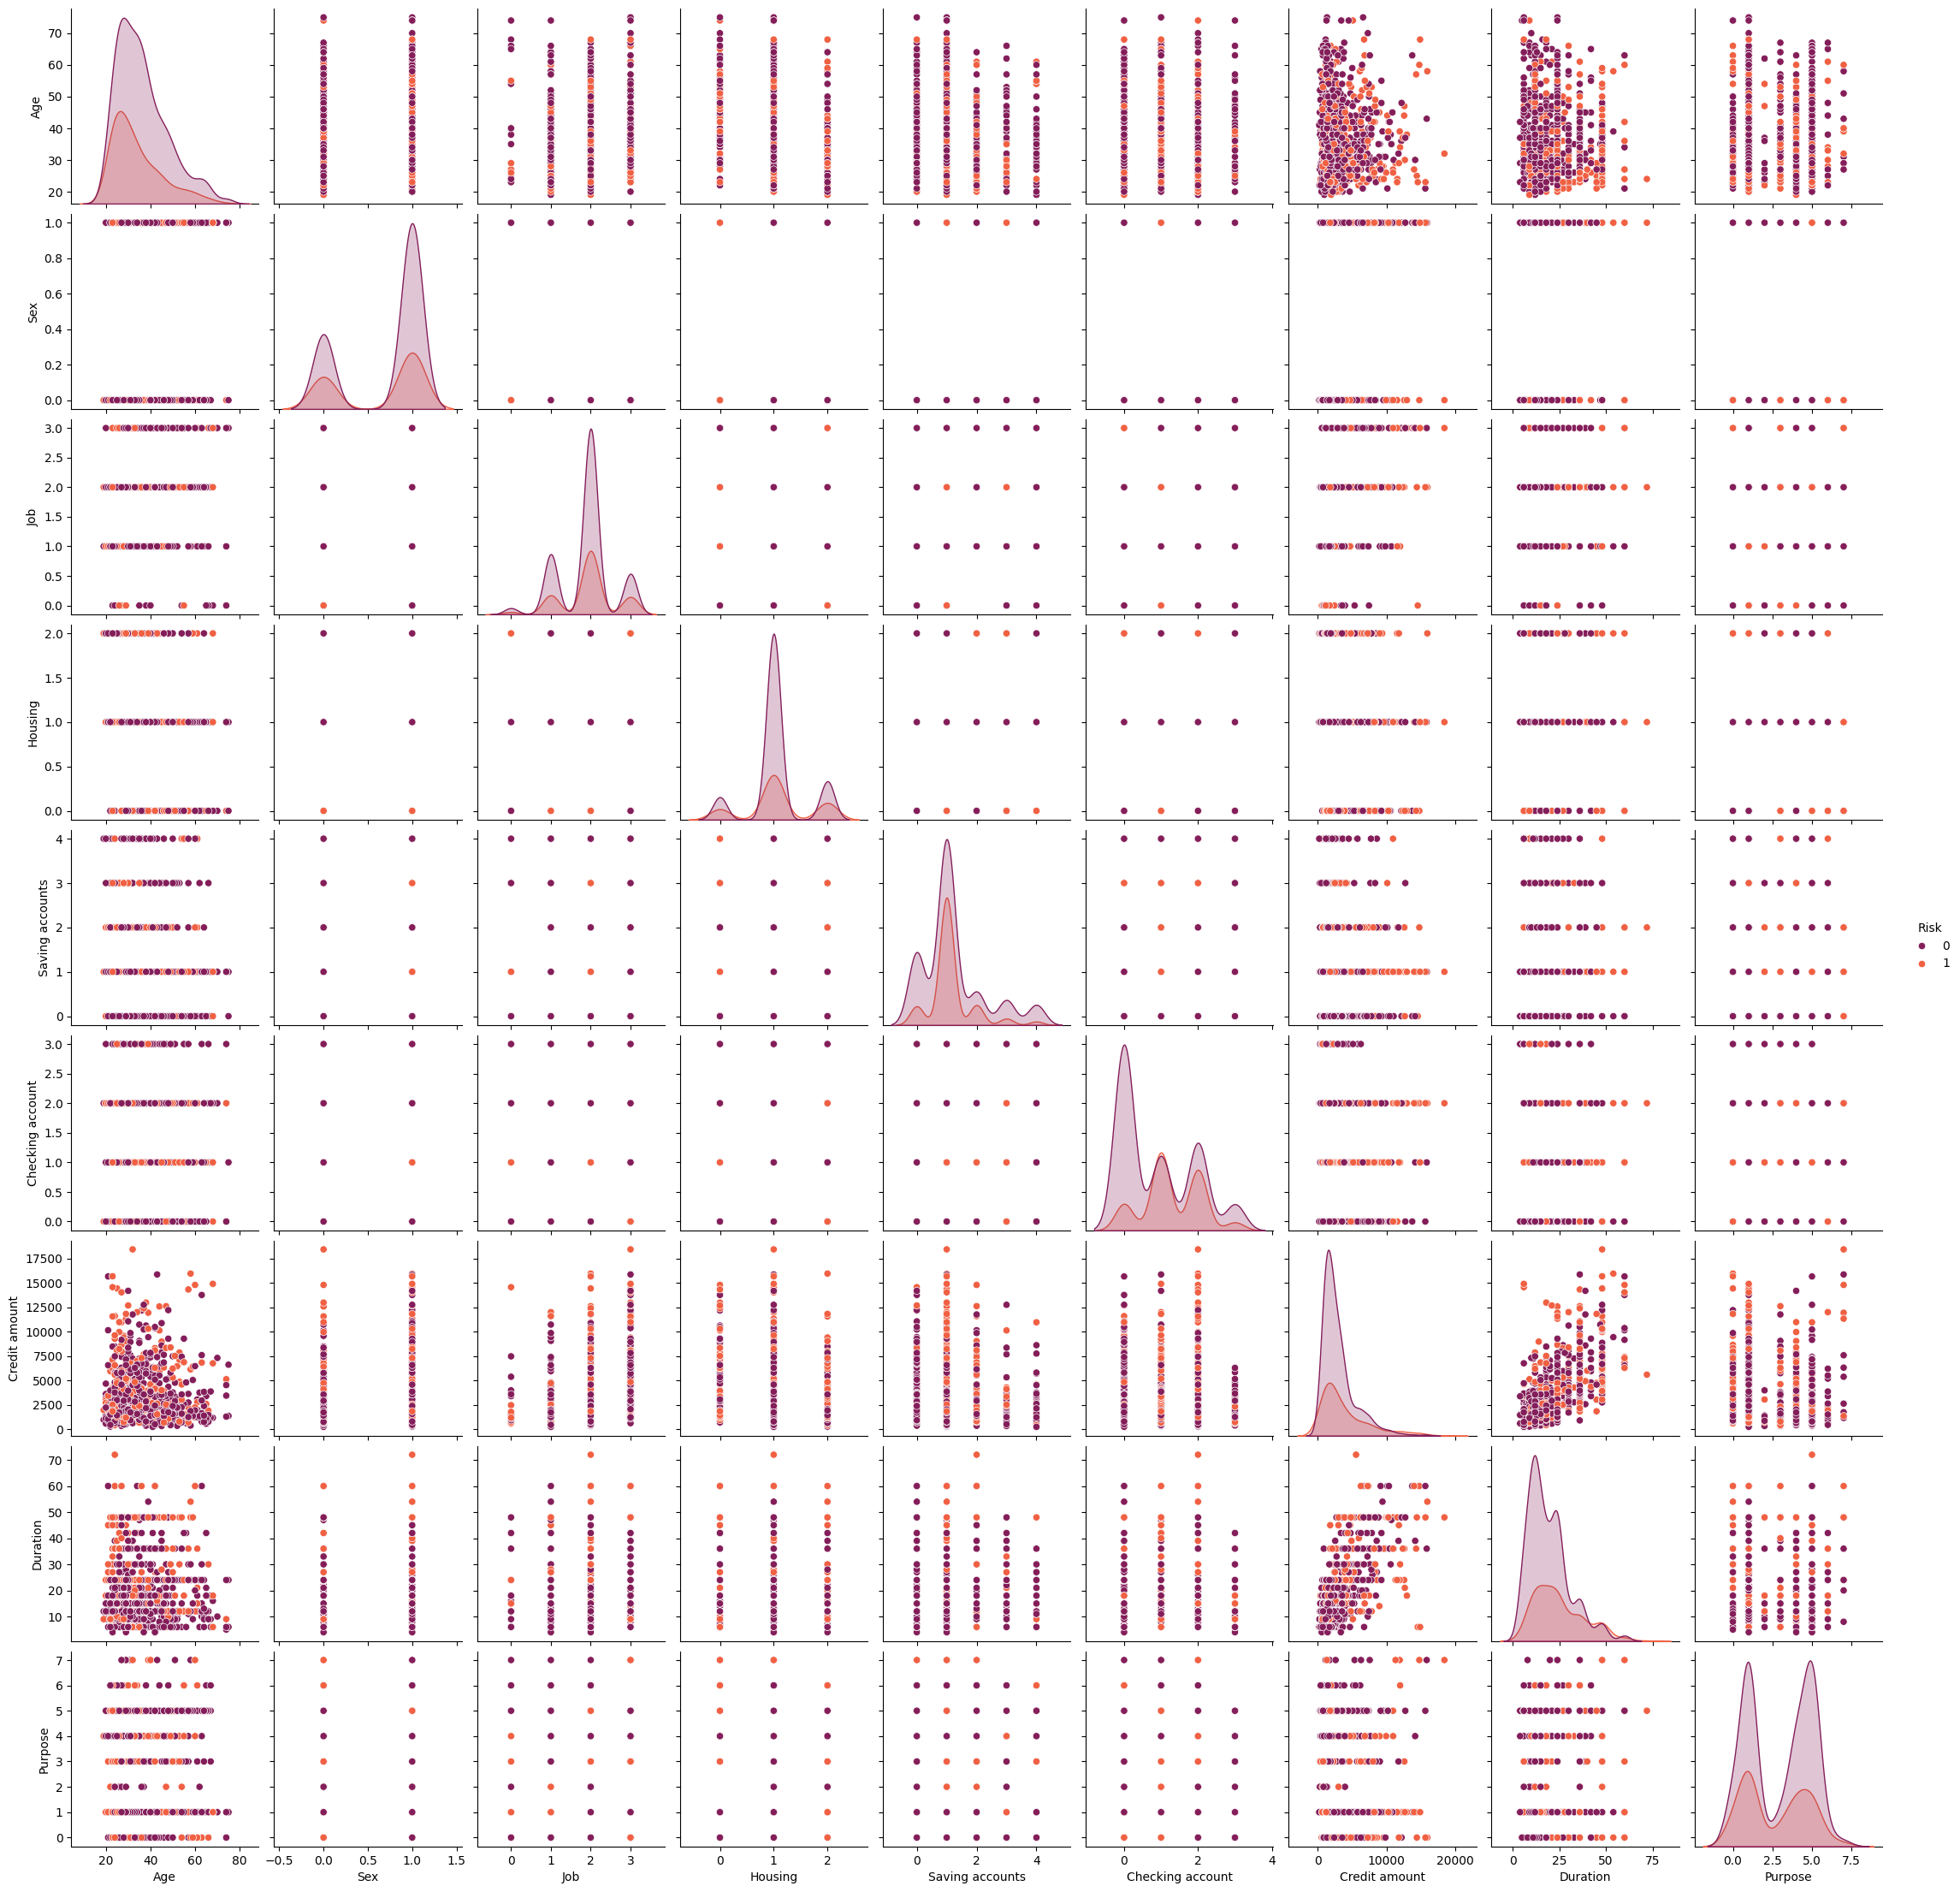

In [89]:
sns.pairplot(df_clean, hue="Risk", palette='rocket')


수치형 변수들만 확인되기 때문에, 수치형이 아닌 변수들은 전처리를 통해 수치형으로 변경해야 한다.

- 결과해석
    - Credit amount와 Duration은 미약하게 양의 상관관계가 있어보임.
    - Job과 Credit amount : Job이 전문화될수록(=3이 될수록) Credit amount가 많은 경우가 늘어난다. 

<Axes: xlabel='Age', ylabel='Percent'>

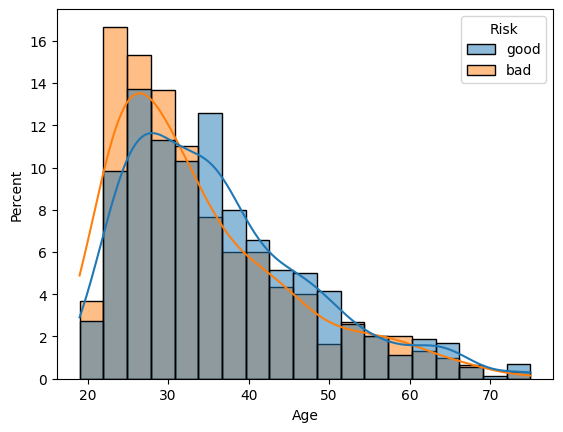

In [ ]:
# Age 시각화 : Risk 별로 나이대 분포가 어떤지 확인
sns.histplot(
    df_clean
    , x='Age'
    , kde=True
    , hue='Risk'
    , stat='percent'
    , common_norm=False         # 구릅별 독립화 false니까 안하겠다 > 각 그룹(Risk)별로 따로 100%를 기준으로 퍼센트를 계산하겠다
)



상대적으로 저 연령대(20대 초중반)에는 신용 위험도가 높은 경향이 있고, 반대로 30대 중반 이후에는 상대적으로 신용위험도가 낮은 편인 것을 확인하였다.

<Axes: xlabel='Sex', ylabel='Percent'>

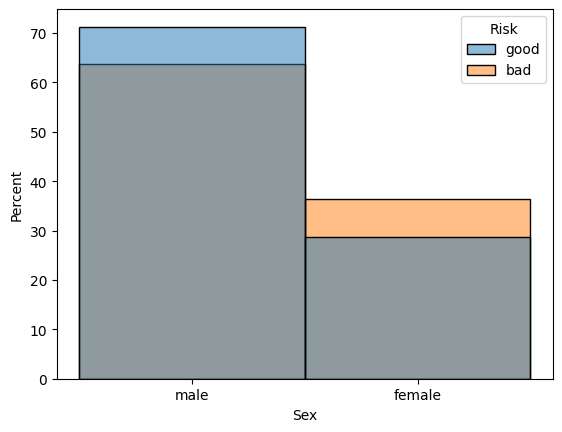

In [42]:
sns.histplot(df_clean,x='Sex', hue='Risk', stat='percent', common_norm=False)

미세하게 남자가 상대적으로 신용위험도가 낮은 비중이 조금 더 있었다.

<Axes: xlabel='Job', ylabel='Percent'>

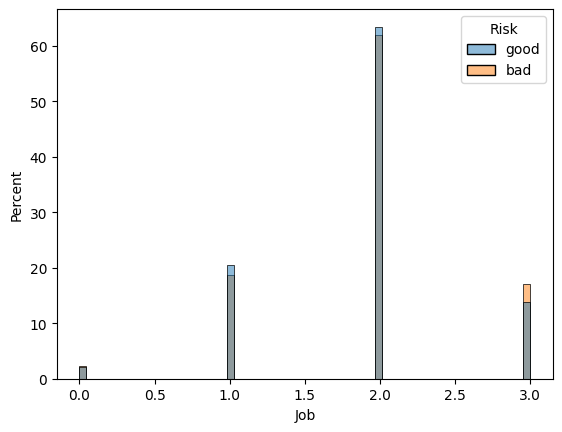

In [43]:
# Risk별 직업 분포
sns.histplot(df_clean,x='Job', hue='Risk', stat='percent', common_norm=False)

### 숙련직 (job2)의 비중이 높다. 숙련직에서는 신용 위험도가 높은 비중이 살짝 더 높다. 

<Axes: xlabel='Housing', ylabel='Percent'>

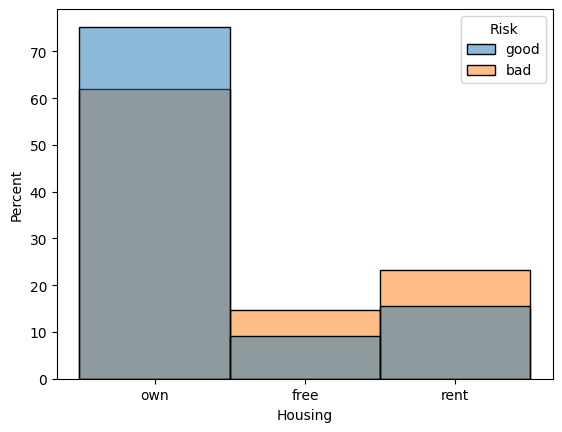

In [44]:
# Risk별 주거형태 분포
sns.histplot(df_clean,x='Housing', hue='Risk', stat='percent', common_norm=False)

<Axes: xlabel='Checking account', ylabel='Percent'>

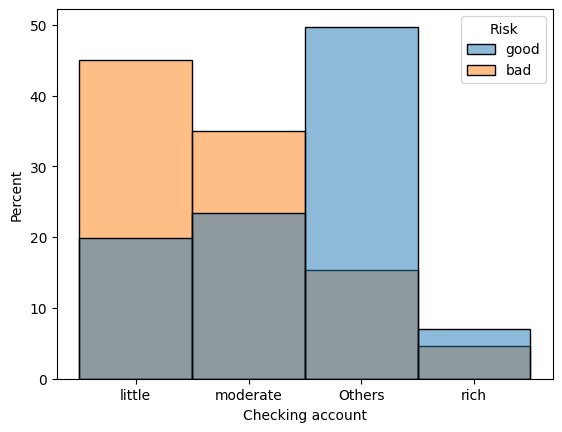

In [45]:
# Risk별 주거형태 분포
sns.histplot(df_clean,x='Checking account', hue='Risk', stat='percent', common_norm=False)

<Axes: xlabel='Checking account', ylabel='Percent'>

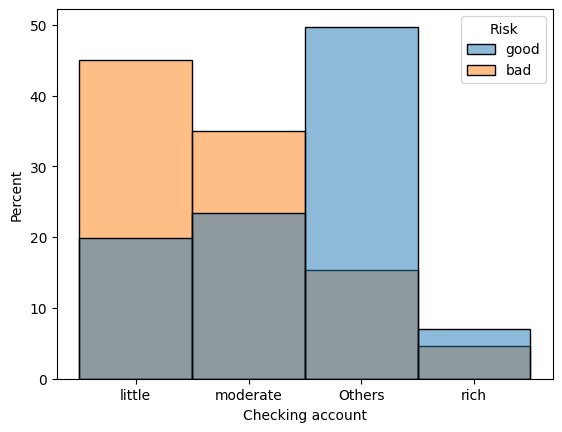

In [46]:
# Checking account별 주거형태 분포
sns.histplot(df_clean,x='Checking account', hue='Risk', stat='percent', common_norm=False)

<Axes: xlabel='Saving accounts', ylabel='Percent'>

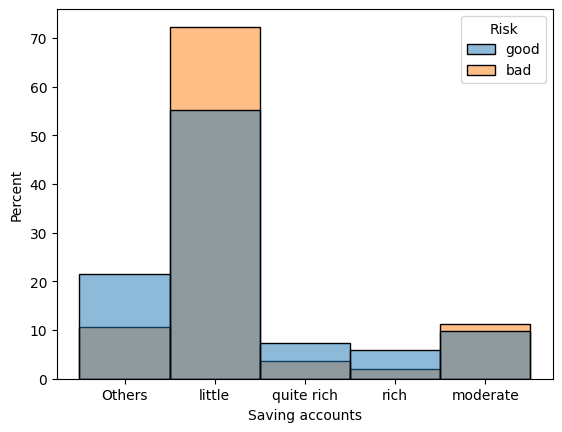

In [47]:
# Saving Account별 주거형태 분포
sns.histplot(df_clean,x='Saving accounts', hue='Risk', stat='percent', common_norm=False)

잔고가 적으면 신용 위험도가 높다.
잔고가 많으면 신용 위험도가 낮다.

<Axes: xlabel='Credit amount', ylabel='Percent'>

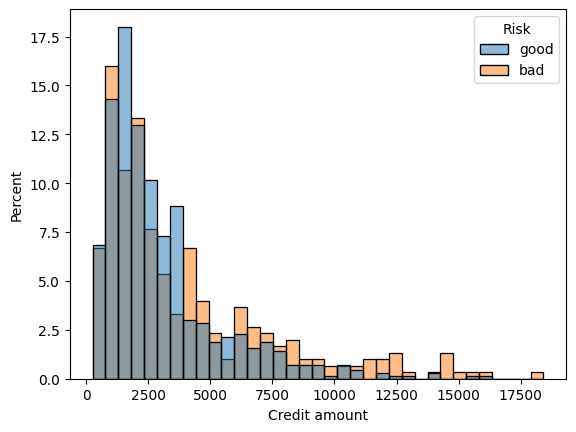

In [48]:
# Credit amount별 주거형태 분포
sns.histplot(df_clean,x='Credit amount', hue='Risk', stat='percent', common_norm=False)

### 예금 보유량이 많을수록 상대적으로 위험도가 높은 사람이 많다.

<Axes: xlabel='Duration', ylabel='Percent'>

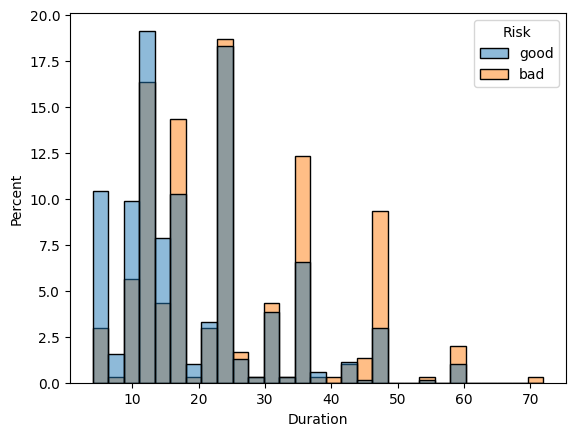

In [49]:
# Duration별 주거형태 분포
sns.histplot(df_clean,x='Duration', hue='Risk', stat='percent', common_norm=False)

### 예치 기간이 긴 사람은 상대적으로 위험도가 높다.

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'radio/TV'),
  Text(1, 0, 'education'),
  Text(2, 0, 'furniture/equipment'),
  Text(3, 0, 'car'),
  Text(4, 0, 'business'),
  Text(5, 0, 'domestic appliances'),
  Text(6, 0, 'repairs'),
  Text(7, 0, 'vacation/others')])

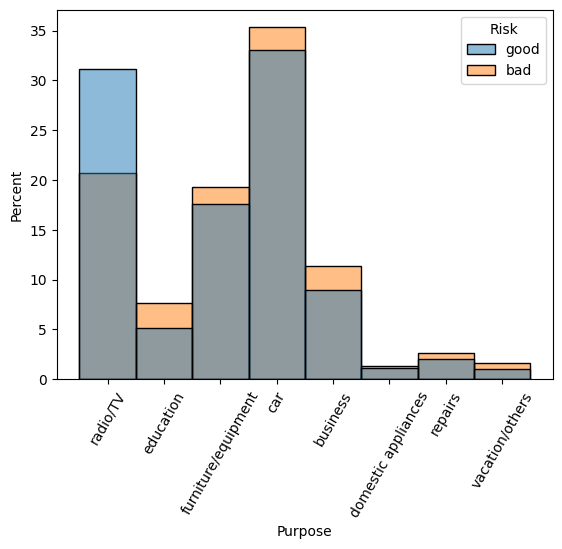

In [50]:
# Purpose별 주거형태 분포
sns.histplot(df_clean,x='Purpose', hue='Risk', stat='percent', common_norm=False)
plt.xticks(rotation=60)

### 위험도가 낮은 사람들은 주로 라디오TV, 자동차 등을 구매하는 목적으로 예금한다. 위홈도가 높은 사람은 자가용 마련 목적이 가장 큰 것을 볼수있다.

# 4. 데이터 전처리
- 카테고리형 변수를 수치형 변수로 변환
- 입력 변수들의 값의 크기 범위를 조정하기위한 정규화
- 학습 데이터와 테스트 데이터 분리

In [51]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   1000 non-null   object
 5   Checking account  1000 non-null   object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


In [52]:
# 카테고리형 변수를 수치형 변수로 변환  (Sex, Housing, Saving accounts, Checking account, Purpose)
ord_encoder = OrdinalEncoder(dtype=np.int32)

non_numeric_features = [
    'Sex',                  # 성별
    "Housing",              # 주거형태
    "Saving accounts",      # 저축계좌
    "Checking account",      # 당좌 예금
    "Purpose"                # 대출 목적
]
df_clean[non_numeric_features] = ord_encoder.fit_transform(df_clean[non_numeric_features])

df_clean

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,1,0,1,1169,6,5,good
1,22,0,2,1,1,2,5951,48,5,bad
2,49,1,1,1,1,0,2096,12,3,good
3,45,1,2,0,1,1,7882,42,4,good
4,53,1,2,0,1,1,4870,24,1,bad
...,...,...,...,...,...,...,...,...,...,...
995,31,0,1,1,1,0,1736,12,4,good
996,40,1,3,1,1,1,3857,30,1,good
997,38,1,2,1,1,0,804,12,5,good
998,23,1,2,0,1,1,1845,45,5,bad


범주형 변수들이 수치형 값으로 바뀌었다.

In [53]:
ord_encoder.categories_

[array(['female', 'male'], dtype=object),
 array(['free', 'own', 'rent'], dtype=object),
 array(['Others', 'little', 'moderate', 'quite rich', 'rich'], dtype=object),
 array(['Others', 'little', 'moderate', 'rich'], dtype=object),
 array(['business', 'car', 'domestic appliances', 'education',
        'furniture/equipment', 'radio/TV', 'repairs', 'vacation/others'],
       dtype=object)]

In [54]:
# Risk도 수치형 변수로 변환한다. (good -> 0, bad -> 1)
df_clean['Risk'] = df_clean['Risk'].map({'good':0,'bad':1})
df_clean

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,1,0,1,1169,6,5,0
1,22,0,2,1,1,2,5951,48,5,1
2,49,1,1,1,1,0,2096,12,3,0
3,45,1,2,0,1,1,7882,42,4,0
4,53,1,2,0,1,1,4870,24,1,1
...,...,...,...,...,...,...,...,...,...,...
995,31,0,1,1,1,0,1736,12,4,0
996,40,1,3,1,1,1,3857,30,1,0
997,38,1,2,1,1,0,804,12,5,0
998,23,1,2,0,1,1,1845,45,5,1


### 학습, 테스트 데이터 분리
- X,y 데이터를 만들어줘야 한다.

In [55]:
X = df_clean.drop('Risk',axis=1)    # 입력 데이터 X
X

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,1,2,1,0,1,1169,6,5
1,22,0,2,1,1,2,5951,48,5
2,49,1,1,1,1,0,2096,12,3
3,45,1,2,0,1,1,7882,42,4
4,53,1,2,0,1,1,4870,24,1
...,...,...,...,...,...,...,...,...,...
995,31,0,1,1,1,0,1736,12,4
996,40,1,3,1,1,1,3857,30,1
997,38,1,2,1,1,0,804,12,5
998,23,1,2,0,1,1,1845,45,5


In [58]:
y = df_clean['Risk']    # 입력 데이터 y
y

0      0
1      1
2      0
3      0
4      1
      ..
995    0
996    0
997    0
998    1
999    0
Name: Risk, Length: 1000, dtype: int64

### random_state : 컴퓨터는 완벽한 랜덤이 없기 때문에 난수처럼 보이는 수들은 하나씩 생성해주는 형태로 유사 난수 생성기를 사용한다.
### random_state등을 사용하며ㅛㄴ 이 시작점을 고정시켜서 같은 결과가 나오도록한다.

In [61]:
# train_test_split으로 데이터를 8:2 비율로 나눈ㄷ자. (random_state=SEED, stratify=y)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=SEED,stratify=y)

In [63]:
print(
    f"신용도가 좋은 경우: {len(df_clean[df_clean['Risk']==0])}개\n"
    f"신용도가 나쁜 경우: {len(df_clean[df_clean['Risk']==1])}개"
)


신용도가 좋은 경우: 700개
신용도가 나쁜 경우: 300개


### 신용도 좋은경우와 나쁜경우가 7:3인데, stratify 옵션을 주지 않으면 학습 및 테스트 데이터가 이 비율대로 데이터가 분할되지 않는경우가 있다. 이걸 기존 데이터의 타겟 비율대로 맞춰주는 것이 stratify 옵션이다. 

### 4-3 정규화
- MinMaxScaler : 각 변수의 값을 0과 1 사이의 값으로 변환한다.

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)     # 학습데이터로 정규화 기준을 학습하고 변환
X_test = scaler.transform(X_test)           # test데이터는 학습 데이터에서 구한 (최소/최대값)으로 변환 적용***중요***




# 5. 모델 학습 
    - Logistic Regression(분류모델)
    - y값 범위가 0~1 사이 (출력값을 바로 확률로 계산)
    - 시그모이드 함수 적용하면 임계점 0.5로 결정하면 0.5 이상은 1로, 0.5 이하는 0으로 판단한다.


In [69]:
lr_model = LogisticRegression()
lr_model.fit(X_train,y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

혼동행력 (Confusion Matrix)
- 실제로 1인것을 1로 예측해서 맞은경우 - TP(True Positive)
- 실제로 1인것을 0으로 예측해서 틀린경우 - FN(False Nagative)
- 실제로 0인것을 1로 예측해서 틀린경우 -  FP(False Positive)
- 실제로 0인것을 0으로 예측해서 맞은경우 - TN(True Negative)

|   ---  | 예측 1 | 예측 0 |
|--------|--------|-------|
| 실제 1 |  TP    |   FN   |
| 실제 0 |   FP   |   TN   |

- 정확도 (보편적인 지표이지만 비율에 취약하다.)
    - Accuracy = TP + TN (TP+FN+FP+TN)
    
- 정밀도 : 모델이 Positive로 예측한 결과 중 실제로도 Positive인 것의 비율
    - 실제 negative인 것을 positve로 예측하면 곤란한 상황. (예 : 스팸메일 => 일반메일을 스팸메일함에 넣어버림)
    - Precision = TP / (TP + FP)
- 재현율 : 실제로 Positive인 것들 중 모델이 Positive로 예측한 것의 비율
    - 실제 Positive인 것을 Negative로 예측하면 곤란한 상황. (예: 암 예측)
    - RECALL = TP / (TP + FN)

- F1스코어 : F-Score라고도 한다. Precision과 REcall 값의 조화 평균
    -F1스코어 = 2 * (PRECISION * RECALL) /  (PRECISION + RECALL) = 2TP(2TP+FP+FN)

위 4가지 지표는 0~1 사이의 값이 나온다.
1에 가까울수록 좋은 모델이다.

신용 위험도 평가 데이터셋에서 중요한 지표를 따져보면 신용 위험도가 높은 사람한테 대출을 해주면 안된다. 

위험도가 높다(Positive)인 사람을 위험도가 낮다(Negative)로 판단하면 안된다. (재현율)
>>>
위험도가 낮은(Negative) 사람을 위험도가 높다(Positive)로 판단해서 대출이 안나오게 됐다 =>
우수고객이 불만을 가진다. (정밀도)

- F1 스코어 (클래스 불균형 시에도 강하다.)
일단 데이터셋이 타겟변수 비율이 7:3이기 때문에 클래스 불군형이 어느정도 있다고 봐야하고 F1스코어를 보는것이 확실히 좋다.


In [76]:
def check_metrics(model, model_name, X_train, X_test, y_train, y_test):
    y_pred_train = model.predict(X_train)   # 학습데이터 예측값 생성
    y_pred_test = model.predict(X_test)     # 테스트 데이터 예측값 생성
    
    # 학습 데이터 평가 지표 계산
    acc_train = accuracy_score(y_train,y_pred_train)              # 정확도
    precision_train = precision_score(y_train,y_pred_train)       # 정밀도
    recall_train = recall_score(y_train,y_pred_train)             # 재현율
    f1_train = f1_score(y_train,y_pred_train)                     # F1-Score
    
    # 테스트 데이터 평가 지표 계산
    
    acc_test = accuracy_score(y_test,y_pred_test)                 # 정확도
    precision_test = precision_score(y_test,y_pred_test)          # 정밀도
    recall_test = recall_score(y_test,y_pred_test)                # 재현율
    f1_test = f1_score(y_test,y_pred_test)                        # F1-Score
    
    print("훈련 데이터 정확도 : ",acc_train)                       # 정확도
    print("훈련 데이터 정밀도 : ",precision_train)                 # 정밀도
    print("훈련 데이터 재현율 : ",recall_train)                    # 재현율
    print("훈련 데이터 F1-Score : ",f1_train)                      # F1-Score
    
    print("테스트 데이터 정확도 : ",acc_test)                      # 정확도
    print("테스트 데이터 정밀도 : ",precision_test)                # 정밀도
    print("테스트 데이터 재현율 : ",recall_test)                   # 재현율
    print("테스트 데이터 F1-Score : ",f1_test)                     # F1-Score
    


In [77]:
check_metrics(lr_model, "Logistic Regression", X_train, X_test, y_train, y_test)

훈련 데이터 정확도 :  0.7075
훈련 데이터 정밀도 :  0.5441176470588235
훈련 데이터 재현율 :  0.15416666666666667
훈련 데이터 F1-Score :  0.24025974025974026
테스트 데이터 정확도 :  0.705
테스트 데이터 정밀도 :  0.5294117647058824
테스트 데이터 재현율 :  0.15
테스트 데이터 F1-Score :  0.23376623376623376


### 실습 데이터의 Risk에서 0인 데이터와 1인 데이터의 비율이 7:3으로 1:1로 맞아떨어지지 않는다.
### 즉 클래스 불균형 문제가 있다.

### 일단은 모델문제일수도 있으니 다른 모델로 성능개선 여부를 확인한다.

- Naive Bayes 모델 사용
    - 조건부 확률을 사용한다.

In [78]:
nb_model = GaussianNB() # 나이브베이즈 모델의 일종인 Gaussian  나이브 베이즈 모델
nb_model.fit(X_train,y_train)

check_metrics(nb_model,"Naive Bayes",X_train,X_test,y_train,y_test)

훈련 데이터 정확도 :  0.725
훈련 데이터 정밀도 :  0.5704225352112676
훈련 데이터 재현율 :  0.3375
훈련 데이터 F1-Score :  0.42408376963350786
테스트 데이터 정확도 :  0.71
테스트 데이터 정밀도 :  0.5277777777777778
테스트 데이터 재현율 :  0.31666666666666665
테스트 데이터 F1-Score :  0.3958333333333333


### Logisitc Regression 모델보다는 성능이 낫다.
    - 마진을 최대화시키는 서포트 벡터를 찾는다.
    - 마진을 최대화하는 이유는 주어진 데이터 뿐 아니라 나중에 생성되거나 들어올 새로운 데이터를 분류 할 때 오분류할 가능성을 최소화 하기 위ㅐ서이다.

In [79]:
# 분류용 모델 SVC, 회귀용 모델은 SVR
svm_model = SVC(random_state=SEED)

# 학습 데이터로 학습
svm_model.fit(X_train,y_train)

# 모델의 성능
check_metrics(svm_model,"Naive Bayes",X_train,X_test,y_train,y_test)

훈련 데이터 정확도 :  0.7525
훈련 데이터 정밀도 :  0.8
훈련 데이터 재현율 :  0.23333333333333334
훈련 데이터 F1-Score :  0.36129032258064514
테스트 데이터 정확도 :  0.745
테스트 데이터 정밀도 :  0.7142857142857143
테스트 데이터 재현율 :  0.25
테스트 데이터 F1-Score :  0.37037037037037035


로지스틱 회귀보다는 좀 낫다. 그리고 나이브 베이즈보다는 살짝 못하다.
Decision Tree와 Random Forest 모델